In [118]:
##Including Imports
import pandas as pd
import math
import numpy as np
import mpu
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

In [104]:
data = pd.read_csv("data.csv")
df = data.drop(data.columns[[11, 12, 13, 14]], axis=1)
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG
0,16957943,ISC,1907-01-04,05:19:11.80,1.8725,94.2091,15.0,TRUE,ISC,MS,7.8
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5


In [105]:
#Current Dimension of DataFrame
df.shape

(347, 11)

In [106]:
def get_dist(lat1, lang1, lat2, lang2):
    dist = mpu.haversine_distance((lat1, lang1), (lat2, lang2))
    return abs(dist)

def get_diff_days(date1, date2):
    date_format = "%Y-%m-%d"
    return abs((datetime.strptime(date1, date_format) - datetime.strptime(date2, date_format)).days)
    
def get_window(M):
    r = math.exp(-1.024 + 0.804 * M)
    t = math.exp(-2.870 + 1.235 * M)
    return r, t

def filtering(df):
    for index1, row1 in df.iterrows():
        M = row1["MAG"]
        r = math.exp(-1.024 + 0.804 * M)
        t = math.exp(-2.870 + 1.235 * M)
        for index2, row2 in df.iterrows():
            if (row2["MAG"] <= row1["MAG"] and (index1 is not index2) and 
                    (get_dist(row1["LAT"], row1["LON"], row2["LAT"], row2["LON"]) <= r+60) 
                       and (get_diff_days(row1["DATE"], row2["DATE"]) <= t+15)):
                    df.drop(index2,inplace=True)

In [110]:
filtering(df)

In [111]:
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG
0,16957943,ISC,1907-01-04,05:19:11.80,1.8725,94.2091,15.0,TRUE,ISC,MS,7.8
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5


In [113]:
#Current shape of DataFrame
df.shape

(164, 11)

In [114]:
date_format = "%Y/%m/%d"

int_time = []
int_time.append(0)
date_values = df["DATE"].values
for i in range(len(date_values)):
    if(i != 0):
        int_time.append(get_diff_days(date_values[i], date_values[i-1]))

df["INTEREVENT TIME"] = int_time
df["INTEREVENT TIME"] /= (12*30)
df = df[df["INTEREVENT TIME"] != 0]

In [115]:
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG,INTEREVENT TIME
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6,7.580556
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5,4.305556
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3,0.327778
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5,0.205556
5,912979,ISC,1919-10-12,21:48:31.74,-4.1786,101.7521,25.0,TRUE,ISC,MS,6.5,0.536111


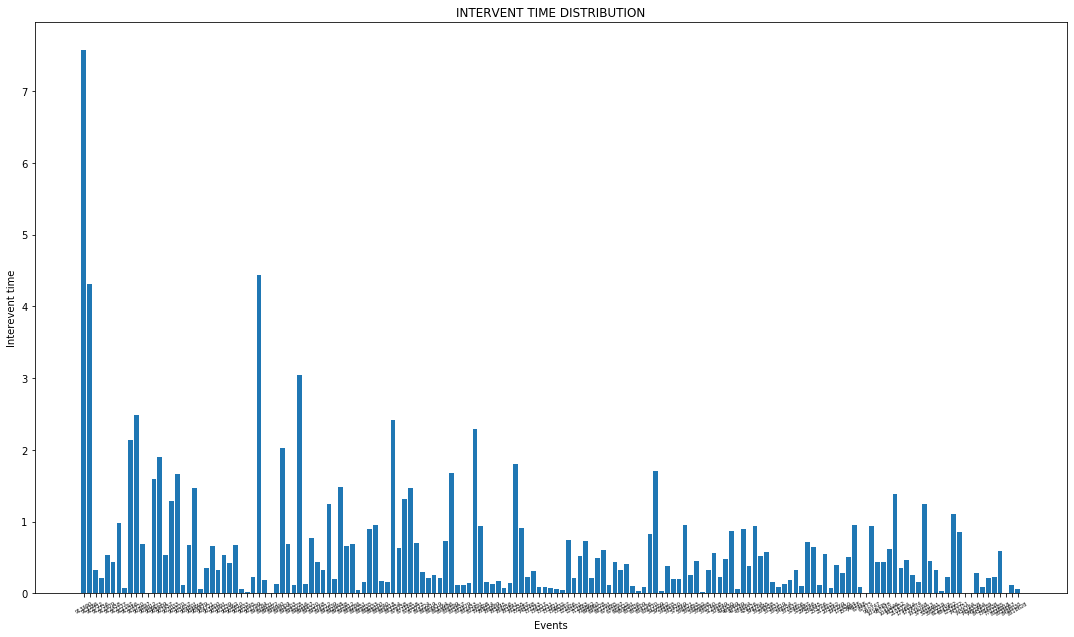

In [116]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

index = np.arange(len(df))
plt.xlabel('Events', fontsize=10)
plt.ylabel('Interevent time', fontsize=10)
plt.xticks(index, df["EVENTID"].values, fontsize=5, rotation=30)
plt.title('INTERVENT TIME DISTRIBUTION')
plt.bar(index, df["INTEREVENT TIME"])
plt.show()

In [117]:
df2 = pd.DataFrame()
df2["INTEREVENT TIME"] = df["INTEREVENT TIME"]
df2.to_csv("interevent_time.csv")